<a href="https://colab.research.google.com/github/advaitkumar3107/GNR-652-Project/blob/master/Edge_Connect_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
from random import randint
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from scipy import ndimage
from scipy.ndimage.filters import convolve
from scipy import misc
import scipy.misc as sm
from skimage.feature import canny
from IPython.display import HTML
from google.colab import drive 
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/
import model
device = 'cuda'
np.random.seed(1)
torch.cuda.empty_cache()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive


In [0]:
def rgbtogray(image): #function that converts an rgb to grayscale image
  r,g,b = image[:,0,:,:], image[:,1,:,:], image[:,2,:,:]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  gray = gray.unsqueeze_(1)
  return gray

def regular_mask_grayscale(img,random_num):  #function that creates a square mask randomly that masks 25% of the image pixels
  k = 0
  b_size = img.size(0)
  mask_1 = torch.zeros((b_size,1,256,256))
  masked_image_1 = torch.zeros((b_size,1,256,256))
  for image in img:
    masked_image = image.squeeze_(0)*1
    rand = random_num
    mask = torch.zeros((256,256))
    for i in range(rand-10,rand+11):
      for j in range(rand-10,rand+11):
        masked_image[i][j] = 1.0
        mask[i][j] = 1.0
    masked_image = masked_image.unsqueeze_(0)
    mask = mask.unsqueeze_(0)
    mask_1[k,:,:,:] = mask
    masked_image_1[k,:,:,:] = masked_image
    k = k+1
  return masked_image_1,mask_1

def irregular_mask(img):  #function that randomly masks 30% of the image pixels
  mask = np.zeros((256,256))
  for i in range(140):
    for j in range(140):
      mask[i][j] = 1.0
  mask = mask.ravel()
  np.random.shuffle(mask)
  mask = mask.reshape((1,256,256))
  masked_img = img*1
  masked_img = np.maximum(masked_img,mask)
  return masked_img, mask

def gram_matrix(image):

  b,ch, h, w = image.size()
  f = image.view(b,ch, w * h)
  f_T = f.transpose(1,2)
  G = f.bmm(f_T) / (h * w * ch)

  return G

def canny_edge_detector(image):
  b_size = image.size(0)
  temp1 = torch.zeros((b_size,1,256,256))
  i = 0
  for images in image:
    temp = images.squeeze_(0)
    canny_edge = canny(temp.cpu().numpy())
    canny_edge = torch.from_numpy(canny_edge).unsqueeze_(0)
    temp1[i,:,:,:] = canny_edge
    i = i+1
  return temp1

In [0]:
##### MODEL ARCHITECTURES #########

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms


class residual_block_edge(nn.Module):
  def __init__(self,ngpu):
    super(residual_block_edge,self).__init__()
    self.ngpu = ngpu
    self.layer1 = nn.Sequential(nn.ReflectionPad2d(1), nn.utils.spectral_norm(nn.Conv2d(256,256,3,1,padding = 0)), nn.InstanceNorm2d(256), nn.ReLU(True))
    self.layer2 = nn.Sequential(nn.ReflectionPad2d(1), nn.utils.spectral_norm(nn.Conv2d(256,256,3,1,padding = 0)), nn.InstanceNorm2d(256))

  def forward(self,x):
    y = self.layer1(x)
    y = self.layer2(y)
    out = x + y
    return out



class residual_block_completion(nn.Module):
  def __init__(self,ngpu):
    super(residual_block_completion,self).__init__()
    self.ngpu = ngpu
    self.layer1 = nn.Sequential(nn.ReflectionPad2d(1),nn.Conv2d(256,256,3,1,padding = 0), nn.InstanceNorm2d(256), nn.ReLU(True))
    self.layer2 = nn.Sequential(nn.ReflectionPad2d(1),nn.Conv2d(256,256,3,1,padding = 0), nn.InstanceNorm2d(256))

  def forward(self,x):
    y = self.layer1(x)
    y = self.layer2(y)
    out = x + y
    return out




class generator1(torch.nn.Module):
  def __init__(self, ngpu):
    super(generator1,self).__init__()
    self.ngpu = ngpu
    self.c64 = nn.Sequential(nn.ReflectionPad2d(3),nn.utils.spectral_norm(nn.Conv2d(3,64,7,1, padding = 0)), nn.InstanceNorm2d(64), nn.ReLU(True))
    self.d128 = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(64,128,4,2,padding = 1)), nn.InstanceNorm2d(128),nn.ReLU(True))
    self.d256 = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(128,256,4,2,padding =1)), nn.InstanceNorm2d(256),nn.ReLU(True))
    self.r256 = residual_block_edge(ngpu)
    self.u128 = nn.Sequential(nn.utils.spectral_norm(nn.ConvTranspose2d(256,128,4,2,padding = 1)), nn.InstanceNorm2d(128), nn.ReLU(True))
    self.u64 = nn.Sequential(nn.utils.spectral_norm(nn.ConvTranspose2d(128,64,4,2,padding = 1)), nn.InstanceNorm2d(64), nn.ReLU(True))
    self.out = nn.Sequential(nn.ReflectionPad2d(3), nn.utils.spectral_norm(nn.Conv2d(64,1,7,1, padding = 0)))

  def forward(self,x):
    x = self.c64(x)
    x = self.d128(x)
    x = self.d256(x)

    for i in range(8):
      x = self.r256(x)
    
    x = self.u128(x)
    x = self.u64(x)
    x = self.out(x)
    out = torch.sigmoid(x)
    return out




class generator2(torch.nn.Module):
  def __init__(self,ngpu):
    super(generator2,self).__init__()
    self.ngpu = ngpu
    self.c64 = nn.Sequential(nn.ReflectionPad2d(3),nn.Conv2d(4,64,7,1,padding = 0), nn.InstanceNorm2d(64), nn.ReLU(True))
    self.d128 = nn.Sequential(nn.Conv2d(64,128,4,2,padding = 1),nn.InstanceNorm2d(128),nn.ReLU(True))
    self.d256 = nn.Sequential(nn.Conv2d(128,256,4,2,padding = 1),nn.InstanceNorm2d(256),nn.ReLU(True))
    self.r256 = residual_block_completion(ngpu)
    self.u128 = nn.Sequential(nn.ConvTranspose2d(256,128,4,2,padding = 1), nn.InstanceNorm2d(128), nn.ReLU(True))
    self.u64 = nn.Sequential(nn.ConvTranspose2d(128,64,4,2,padding = 1),nn.InstanceNorm2d(64), nn.ReLU(True))
    self.out = nn.Sequential(nn.ReflectionPad2d(3), nn.Conv2d(64,3,7,1,padding = 0))

  def forward(self,x):
    x = self.c64(x)
    x = self.d128(x)
    x = self.d256(x)

    for i in range(8):
      x = self.r256(x)

    x = self.u128(x)
    x = self.u64(x)
    x = self.out(x)
    out = torch.tanh(x)
    return out

class discriminator(torch.nn.Module):
  def __init__(self,in_channels,ngpu):
    super(discriminator,self).__init__()
    self.ngpu = ngpu
    self.c1 = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(in_channels,64,4,2,padding = 1)), nn.LeakyReLU(0.2))
    self.c2 = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(64,128,4,2,padding = 1)), nn.LeakyReLU(0.2))
    self.c3 = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(128,256,4,2,padding = 1)), nn.LeakyReLU(0.2))
    self.c4 = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(256,512,4,1,padding = 1)), nn.LeakyReLU(0.2))
    self.c5 = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(512,1,4,1,padding = 1)))

  def forward(self,x):
    c1 = self.c1(x)
    c2 = self.c2(c1)
    c3 = self.c3(c2)
    c4 = self.c4(c3)
    c5 = self.c5(c4)
    out = torch.sigmoid(c5)
    return out, [c1, c2, c3, c4, c5]



class Vgg19(torch.nn.Module):
    def __init__(self):
        super(Vgg19, self).__init__()
        features = list(torchvision.models.vgg19(pretrained = True).features)[:31]
        self.features = nn.ModuleList(features).eval() 
        
    def forward(self, x):
        results = []
        for ii,model in enumerate(self.features):
            x = model(x)
            if ii in {1,6,11,20,29}:
                results.append(x)
        return results




def weights_init(m):
  classname = m.__class__.__name__
  if hasattr(m, 'weight') and (classname.find('Conv') != -1):
    if hasattr(m, 'bias') and m.bias is not None:
      nn.init.constant_(m.bias.data, 0.0)
    else:
      nn.init.normal_(m.weight.data, 0.0, 0.02)

  elif classname.find('BatchNorm2d') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0.0)

In [0]:
dataset = dset.ImageFolder(root='celeba',
                           transform=transforms.Compose([
                               transforms.Resize(256),
                               transforms.CenterCrop(256),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [0]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset,test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [0]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers = 2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 8, shuffle = True, num_workers = 2)

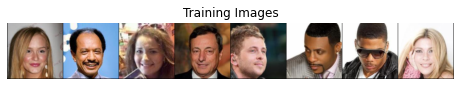

In [0]:
#Plot some training images
train_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(train_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

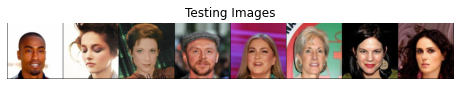

In [0]:
# Plot some testing images
test_batch = next(iter(test_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Testing Images")
plt.imshow(np.transpose(vutils.make_grid(test_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
"""
Creating the new models here for training and testing
"""

Edge_generator = generator1(1).to(device)
Inpaint_generator = generator2(1).to(device)
Edge_discriminator = discriminator(2,1).to(device)
feature_matching_discriminator = discriminator(1,1).to(device)
Inpaint_discriminator = discriminator(4,1).to(device)
vgg19 = Vgg19().to(device)

Edge_generator.load_state_dict(torch.load('Edge_generator.pt'))
Inpaint_generator.load_state_dict(torch.load('Inpaint_generator.pt'))
Edge_discriminator.load_state_dict(torch.load('Edge_discriminator.pt'))
Inpaint_discriminator.load_state_dict(torch.load('Inpaint_discriminator.pt'))

Edge_generator = Edge_generator.eval().to(device)
Inpaint_generator = Inpaint_generator.eval().to(device)

rand_num = np.random.randint(60,195)
test_batch = next(iter(test_dataloader))
test_cpu = test_batch[0].to(device)
b_size = test_cpu.size(0)
I_gray = rgbtogray(test_cpu).to(device)
I_gray_masked, mask = regular_mask_grayscale(I_gray,rand_num)
I_gray_masked = I_gray_masked.to(device)
mask = mask.to(device)

r = test_cpu[:,0,:,:].unsqueeze_(1).to(device)
g = test_cpu[:,1,:,:].unsqueeze_(1).to(device)
b = test_cpu[:,2,:,:].unsqueeze_(1).to(device)

I_gt_r = np.maximum(r.cpu(),mask.cpu()).to(device)
I_gt_b = np.maximum(b.cpu(),mask.cpu()).to(device)
I_gt_g = np.maximum(g.cpu(),mask.cpu()).to(device)

I_gt_masked = torch.cat((I_gt_r,I_gt_g,I_gt_b),1).to(device) #RGB image with mask

C_gt_masked = canny_edge_detector(I_gray_masked).to(device)
edge_generator_input = torch.cat((I_gray_masked, C_gt_masked, mask),1)
C_pred = Edge_generator(edge_generator_input) ### Output after first generator

C_comp = (C_gt_masked + (torch.ones((b_size,1,256,256)).to(device)-mask) * C_pred).to(device)
generator2_input = torch.cat((I_gt_masked,C_comp),1).to(device)
I_pred = Inpaint_generator(generator2_input).to(device)



#Plot the input images with masks
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Input Images")
plt.imshow(np.transpose(vutils.make_grid(I_gt_masked.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Plot the output images
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Output Images")
plt.imshow(np.transpose(vutils.make_grid(I_pred.detach().to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


discriminator(
  (c1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (c2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (c3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (c4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (c5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [0]:
plt.imshow(np.transpose(I_gt_masked[5].cpu().detach(),(1,2,0)))

Beginning Training....
[0/99]	 [0/51]	 D1_loss: -1.3945	 G1_loss: -1.3071	 D2_loss: -1.3738	 G2_loss: 0.1365	
[0/99]	 [1/51]	 D1_loss: -1.3886	 G1_loss: -1.3631	 D2_loss: -1.3707	 G2_loss: 0.2469	
[0/99]	 [2/51]	 D1_loss: -1.3875	 G1_loss: -1.3760	 D2_loss: -1.3712	 G2_loss: 0.1259	
[0/99]	 [3/51]	 D1_loss: -1.3872	 G1_loss: -1.3800	 D2_loss: -1.3782	 G2_loss: 0.1740	
[0/99]	 [4/51]	 D1_loss: -1.3870	 G1_loss: -1.3801	 D2_loss: -1.3796	 G2_loss: 0.1576	
[0/99]	 [5/51]	 D1_loss: -1.3869	 G1_loss: -1.3812	 D2_loss: -1.3806	 G2_loss: 0.2782	
[0/99]	 [6/51]	 D1_loss: -1.3869	 G1_loss: -1.3817	 D2_loss: -1.3709	 G2_loss: 0.1977	
[0/99]	 [7/51]	 D1_loss: -1.3869	 G1_loss: -1.3824	 D2_loss: -1.3779	 G2_loss: 0.1452	
[0/99]	 [8/51]	 D1_loss: -1.3868	 G1_loss: -1.3817	 D2_loss: -1.3680	 G2_loss: 0.1368	
[0/99]	 [9/51]	 D1_loss: -1.3868	 G1_loss: -1.3819	 D2_loss: -1.3794	 G2_loss: 0.1742	
[0/99]	 [10/51]	 D1_loss: -1.3868	 G1_loss: -1.3822	 D2_loss: -1.3509	 G2_loss: 0.1470	
[0/99]	 [11/51]	 D1

KeyboardInterrupt: ignored

In [0]:
plt.imshow(np.transpose(I_pred[5].cpu().detach(),(1,2,0)))